In [100]:
import cv2
import os.path as osp
import math
import json
from PIL import Image

import torch
import numpy as np
import cv2
import albumentations as A
from torch.utils.data import Dataset
from shapely.geometry import Polygon

import random
import matplotlib.pyplot as plt 

In [84]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    """이미지에 하나의 bounding box를 그려넣는 함수
    """
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)


def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    """이미지에 다수의 bounding box들을 그려넣는 함수
    """
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)
        

def gray_mask_to_heatmap(x):
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x


def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """이미지에 map/mask 등을 중첩하여 그려주는 함수
    
    Args:
        image (ndarray): (H, W, C) shaped, float32 or uint8 dtype is allowed.
        score_map (ndarray): (H, W) shaped, float32 or uint8 dtype is allowed.
        heatmap (boot): Wheather to convert `score_map` into a heatmap.
        w_image (float)
        w_map (float)

    Blending weights(`w_image` and `w_map`) are default to (0.4, 0.6).
    """

    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)

    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image

    return cv2.addWeighted(image, w_image, score_map, w_map, 0)

In [109]:
def cal_distance(x1, y1, x2, y2):
    '''calculate the Euclidean distance'''
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)


def move_points(vertices, index1, index2, r, coef):
    '''move the two points to shrink edge
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        index1  : offset of point1
        index2  : offset of point2
        r       : [r1, r2, r3, r4] in paper
        coef    : shrink ratio in paper
    Output:
        vertices: vertices where one edge has been shinked
    '''
    index1 = index1 % 4
    index2 = index2 % 4
    x1_index = index1 * 2 + 0
    y1_index = index1 * 2 + 1
    x2_index = index2 * 2 + 0
    y2_index = index2 * 2 + 1

    r1 = r[index1]
    r2 = r[index2]
    length_x = vertices[x1_index] - vertices[x2_index]
    length_y = vertices[y1_index] - vertices[y2_index]
    length = cal_distance(vertices[x1_index], vertices[y1_index], vertices[x2_index], vertices[y2_index])
    if length > 1:
        ratio = (r1 * coef) / length
        vertices[x1_index] += ratio * (-length_x)
        vertices[y1_index] += ratio * (-length_y)
        ratio = (r2 * coef) / length
        vertices[x2_index] += ratio * length_x
        vertices[y2_index] += ratio * length_y
    return vertices


def shrink_poly(vertices, coef=0.3):
    '''shrink the text region
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        coef    : shrink ratio in paper
    Output:
        v       : vertices of shrinked text region <numpy.ndarray, (8,)>
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    r1 = min(cal_distance(x1,y1,x2,y2), cal_distance(x1,y1,x4,y4))
    r2 = min(cal_distance(x2,y2,x1,y1), cal_distance(x2,y2,x3,y3))
    r3 = min(cal_distance(x3,y3,x2,y2), cal_distance(x3,y3,x4,y4))
    r4 = min(cal_distance(x4,y4,x1,y1), cal_distance(x4,y4,x3,y3))
    r = [r1, r2, r3, r4]

    # obtain offset to perform move_points() automatically
    if cal_distance(x1,y1,x2,y2) + cal_distance(x3,y3,x4,y4) > \
       cal_distance(x2,y2,x3,y3) + cal_distance(x1,y1,x4,y4):
        offset = 0 # two longer edges are (x1y1-x2y2) & (x3y3-x4y4)
    else:
        offset = 1 # two longer edges are (x2y2-x3y3) & (x4y4-x1y1)

    v = vertices.copy()
    v = move_points(v, 0 + offset, 1 + offset, r, coef)
    v = move_points(v, 2 + offset, 3 + offset, r, coef)
    v = move_points(v, 1 + offset, 2 + offset, r, coef)
    v = move_points(v, 3 + offset, 4 + offset, r, coef)
    return v


def get_rotate_mat(theta):
    '''positive theta value means rotate clockwise'''
    return np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])


def rotate_vertices(vertices, theta, anchor=None):
    '''rotate vertices around anchor
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        theta   : angle in radian measure
        anchor  : fixed position during rotation
    Output:
        rotated vertices <numpy.ndarray, (8,)>
    '''
    v = vertices.reshape((4,2)).T
    if anchor is None:
        anchor = v[:,:1]
    rotate_mat = get_rotate_mat(theta)
    res = np.dot(rotate_mat, v - anchor)
    return (res + anchor).T.reshape(-1)


def get_boundary(vertices):
    '''get the tight boundary around given vertices
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the boundary
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    x_min = min(x1, x2, x3, x4)
    x_max = max(x1, x2, x3, x4)
    y_min = min(y1, y2, y3, y4)
    y_max = max(y1, y2, y3, y4)
    return x_min, x_max, y_min, y_max


def cal_error(vertices):
    '''default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot
    calculate the difference between the vertices orientation and default orientation
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        err     : difference measure
    '''
    x_min, x_max, y_min, y_max = get_boundary(vertices)
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    err = cal_distance(x1, y1, x_min, y_min) + cal_distance(x2, y2, x_max, y_min) + \
          cal_distance(x3, y3, x_max, y_max) + cal_distance(x4, y4, x_min, y_max)
    return err


def find_min_rect_angle(vertices):
    '''find the best angle to rotate poly and obtain min rectangle
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the best angle <radian measure>
    '''
    angle_interval = 1
    angle_list = list(range(-90, 90, angle_interval))
    area_list = []
    for theta in angle_list:
        rotated = rotate_vertices(vertices, theta / 180 * math.pi)
        x1, y1, x2, y2, x3, y3, x4, y4 = rotated
        temp_area = (max(x1, x2, x3, x4) - min(x1, x2, x3, x4)) * \
                    (max(y1, y2, y3, y4) - min(y1, y2, y3, y4))
        area_list.append(temp_area)

    sorted_area_index = sorted(list(range(len(area_list))), key=lambda k: area_list[k])
    min_error = float('inf')
    best_index = -1
    rank_num = 10
    # find the best angle with correct orientation
    for index in sorted_area_index[:rank_num]:
        rotated = rotate_vertices(vertices, angle_list[index] / 180 * math.pi)
        temp_error = cal_error(rotated)
        if temp_error < min_error:
            min_error = temp_error
            best_index = index
    return angle_list[best_index] / 180 * math.pi


def is_cross_text(start_loc, length, vertices):
    '''check if the crop image crosses text regions
    Input:
        start_loc: left-top position
        length   : length of crop image
        vertices : vertices of text regions <numpy.ndarray, (n,8)>
    Output:
        True if crop image crosses text region
    '''
    if vertices.size == 0:
        return False
    start_w, start_h = start_loc
    a = np.array([start_w, start_h, start_w + length, start_h, start_w + length, start_h + length,
                  start_w, start_h + length]).reshape((4, 2))
    p1 = Polygon(a).convex_hull
    for vertice in vertices:
        p2 = Polygon(vertice.reshape((4, 2))).convex_hull
        inter = p1.intersection(p2).area
        if 0.01 <= inter / p2.area <= 0.99:
            return True
    return False


def crop_img(img, vertices, labels, length):
    '''crop img patches to obtain batch and augment
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        labels      : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
        length      : length of cropped image region
    Output:
        region      : cropped image region
        new_vertices: new vertices in cropped region
    '''
    n = random.choice([0,1,2,3,4,5,6,7,8,9,10])
    length += n*32
    h, w = img.height, img.width
    # confirm the shortest side of image >= length
    if h >= w and w < length:
        img = img.resize((length, int(h * length / w)), Image.BILINEAR)
    elif h < w and h < length:
        img = img.resize((int(w * length / h), length), Image.BILINEAR)
    ratio_w = img.width / w
    ratio_h = img.height / h
    assert(ratio_w >= 1 and ratio_h >= 1)

    new_vertices = np.zeros(vertices.shape)
    if vertices.size > 0:
        new_vertices[:,[0,2,4,6]] = vertices[:,[0,2,4,6]] * ratio_w
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * ratio_h

    # find random position
    remain_h = img.height - length
    remain_w = img.width - length
    flag = True
    cnt = 0
    while flag and cnt < 1000:
        cnt += 1
        start_w = int(np.random.rand() * remain_w)
        start_h = int(np.random.rand() * remain_h)
        flag = is_cross_text([start_w, start_h], length, new_vertices[labels==1,:])
    box = (start_w, start_h, start_w + length, start_h + length)
    region = img.crop(box)
    if new_vertices.size == 0:
        return region, new_vertices

    new_vertices[:,[0,2,4,6]] -= start_w
    new_vertices[:,[1,3,5,7]] -= start_h
    return region, new_vertices


def rotate_all_pixels(rotate_mat, anchor_x, anchor_y, length):
    '''get rotated locations of all pixels for next stages
    Input:
        rotate_mat: rotatation matrix
        anchor_x  : fixed x position
        anchor_y  : fixed y position
        length    : length of image
    Output:
        rotated_x : rotated x positions <numpy.ndarray, (length,length)>
        rotated_y : rotated y positions <numpy.ndarray, (length,length)>
    '''
    x = np.arange(length)
    y = np.arange(length)
    x, y = np.meshgrid(x, y)
    x_lin = x.reshape((1, x.size))
    y_lin = y.reshape((1, x.size))
    coord_mat = np.concatenate((x_lin, y_lin), 0)
    rotated_coord = np.dot(rotate_mat, coord_mat - np.array([[anchor_x], [anchor_y]])) + \
                                                   np.array([[anchor_x], [anchor_y]])
    rotated_x = rotated_coord[0, :].reshape(x.shape)
    rotated_y = rotated_coord[1, :].reshape(y.shape)
    return rotated_x, rotated_y


def resize_img(img, vertices, size):
    h, w = img.height, img.width
    ratio = size / max(h, w)
    if w > h:
        img = img.resize((size, int(h * ratio)), Image.BILINEAR)
    else:
        img = img.resize((int(w * ratio), size), Image.BILINEAR)
    new_vertices = vertices * ratio
    return img, new_vertices


def adjust_height(img, vertices, ratio=0.2):
    '''adjust height of image to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        ratio       : height changes in [0.8, 1.2]
    Output:
        img         : adjusted PIL Image
        new_vertices: adjusted vertices
    '''
    ratio_h = 1 + ratio * (np.random.rand() * 2 - 1)
    old_h = img.height
    new_h = int(np.around(old_h * ratio_h))
    img = img.resize((img.width, new_h), Image.BILINEAR)

    new_vertices = vertices.copy()
    if vertices.size > 0:
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * (new_h / old_h)
    return img, new_vertices


def rotate_img(img, vertices, angle_range=10):
    '''rotate image [-10, 10] degree to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        angle_range : rotate range
    Output:
        img         : rotated PIL Image
        new_vertices: rotated vertices
    '''
    center_x = (img.width - 1) / 2
    center_y = (img.height - 1) / 2
    angle = angle_range * (np.random.rand() * 2 - 1)
    img = img.rotate(angle, Image.BILINEAR)
    new_vertices = np.zeros(vertices.shape)
    for i, vertice in enumerate(vertices):
        new_vertices[i,:] = rotate_vertices(vertice, -angle / 180 * math.pi, np.array([[center_x],[center_y]]))
    return img, new_vertices


def generate_roi_mask(image, vertices, labels):
    mask = np.ones(image.shape[:2], dtype=np.float32)
    ignored_polys = []
    for vertice, label in zip(vertices, labels):
        if label == 0:
            ignored_polys.append(np.around(vertice.reshape((4, 2))).astype(np.int32))
    cv2.fillPoly(mask, ignored_polys, 0)
    return mask


def filter_vertices(vertices, labels, ignore_under=0, drop_under=0):
    if drop_under == 0 and ignore_under == 0:
        return vertices, labels

    new_vertices, new_labels = vertices.copy(), labels.copy()

    areas = np.array([Polygon(v.reshape((4, 2))).convex_hull.area for v in vertices])
    labels[areas < ignore_under] = 0

    if drop_under > 0:
        passed = areas >= drop_under
        new_vertices, new_labels = new_vertices[passed], new_labels[passed]

    return new_vertices, new_labels


def convert_tensor_to_PIL(image_tensor):
    invTrans = A.Compose([A.Normalize(mean = [ 0., 0., 0. ],std = [ 1/0.229, 1/0.224, 1/0.225 ],max_pixel_value=1/255),A.Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1/255, 1/255, 1/255 ],max_pixel_value=255)])
    img = Image.fromarray((invTrans(image = image_tensor))['image'].astype(np.uint8))
    return img


class SceneTextDataset(Dataset):
    def __init__(self, root_dir, split='train', image_size=1024, crop_size=512, color_jitter=True,
                 normalize=True):
        with open(osp.join(root_dir, 'ufo/random_split/{}.json'.format(split)), 'r') as f:
            anno = json.load(f)

        self.anno = anno
        self.image_fnames = sorted(anno['images'].keys())
        self.image_dir = osp.join(root_dir, 'images')

        self.image_size, self.crop_size = image_size, crop_size
        self.color_jitter, self.normalize = color_jitter, normalize

    def __len__(self):
        return len(self.image_fnames)

    def __getitem__(self, idx):
        image_fname = self.image_fnames[idx]
        image_fpath = osp.join(self.image_dir, image_fname)

        vertices, labels = [], []
        for word_info in self.anno['images'][image_fname]['words'].values():

            points = np.array(word_info['points']).flatten()
            check_point = 0 
            # if len(points) > 8:
            #     check_point = 1
            #     print('*********')
            #     print(image_fname)
            #     print('len(points):',len(points))
            #     print('word_info', len(word_info['points']))

            # 8개넘어가면 안되게끔, polygon에 외접한 직사각형으로 수정!
            if len(points) > 8 : 
                x = [round(points[i]) for i in range(len(points)) if i%2 ==0]
                y = [round(points[i]) for i in range(len(points)) if i%2 !=0]
                tmp_points = np.array([[x_pos, y_pos] for x_pos, y_pos in zip(x,y)])
                rect = cv2.minAreaRect(tmp_points)
                circum_box= cv2.boxPoints(rect)
                points = np.array(circum_box).flatten()

            # if check_point == 1: print('postprocess : ', len(points))
            vertices.append(points)
            labels.append(int(not word_info['illegibility']))


        vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)

        vertices, labels = filter_vertices(vertices, labels, ignore_under=10, drop_under=1)


        image = Image.open(image_fpath)
        image, vertices = resize_img(image, vertices, self.image_size)
        #image, vertices = adjust_height(image, vertices)
        #image, vertices = rotate_img(image, vertices)
        #image, vertices = crop_img(image, vertices, labels, self.crop_size)


        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        image = np.array(image)

        print('before albu',vertices)
        vertices = vertices.reshape([-1,2])

        funcs = []
        funcs.append(A.HorizontalFlip(p=0.01))
        funcs.append(A.RandomRotate90(p=0.2))
        if self.color_jitter:
            funcs.append(A.ColorJitter(0.5, 0.5, 0.5, 0.25))
        funcs.append(A.CLAHE(p=0.2))
        

        transform = A.Compose(funcs, keypoint_params=A.KeypointParams(format='xy'))
        transformed = transform(image = image, keypoints = vertices)
        image = transformed['image']
        vertices = transformed['keypoints']
        vertices = np.array(vertices)
        vertices = vertices.reshape([-1,8])

        image, vertices = crop_img(Image.fromarray(image), vertices, labels, self.crop_size)
        image, vertices = resize_img(image, vertices, self.crop_size)
        image, vertices = adjust_height(image, vertices)
        image, vertices = rotate_img(image, vertices)

        image = np.array(image)
        if self.normalize:
            image = A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225),max_pixel_value=255)(image = image)['image']

        word_bboxes = np.reshape(vertices, (-1, 4, 2))
        print('image.shape:',image.shape)
        print('word_bboxes',word_bboxes)
        roi_mask = generate_roi_mask(image, vertices, labels)

        return image, word_bboxes, roi_mask


In [110]:
DATA_PATH = '/opt/ml/input/data/ICDAR17_Korean'
data = SceneTextDataset(DATA_PATH, split='train', image_size=1024, crop_size=512)

In [111]:
data0 = data[0]
data_0_1 = data0[1]

print(data_0_1)
print('***************')

for i in data_0_1:
    print(i)
    print()

/tmp/ipykernel_31230/2543739821.py:253: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((int(w * ratio), size), Image.BILINEAR)


before albu [[ 33.464054 337.56863  253.9085   339.66013  247.63399  433.77777
   52.705883 433.77777 ]
 [283.60785  331.71243  485.22876  335.89542  483.13727  433.77777
  289.04575  433.77777 ]
 [523.7124   331.71243  739.13727  327.52942  732.86273  429.5948
  529.98694  427.50327 ]
 [ 45.594772 455.52942  239.68628  451.7647   232.99347  543.37256
   51.86928  541.69934 ]
 [296.15686  455.52942  488.57516  457.6209   501.54248  535.42487
  300.33987  549.6471  ]
 [542.1177   455.52942  727.42487  457.6209   739.13727  543.37256
  510.74512  553.41174 ]]
image.shape: (475, 512, 3)
word_bboxes [[[-131.16789614   20.65217104]
  [  76.30273898   18.19747856]
  [  72.09405436  100.48175223]
  [-111.32864166  104.26679917]]

 [[ 104.1059514    10.68264222]
  [ 293.90177249   10.41928042]
  [ 293.69702325   95.90883046]
  [ 111.06153111   99.67763293]]

 [[ 330.03860803    6.02037452]
  [ 532.67291288   -1.81434189]
  [ 528.60737323   87.40810346]
  [ 337.66841383   89.52162738]]

 [[-117

/tmp/ipykernel_31230/2543739821.py:271: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((img.width, new_h), Image.BILINEAR)
/tmp/ipykernel_31230/2543739821.py:292: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.rotate(angle, Image.BILINEAR)


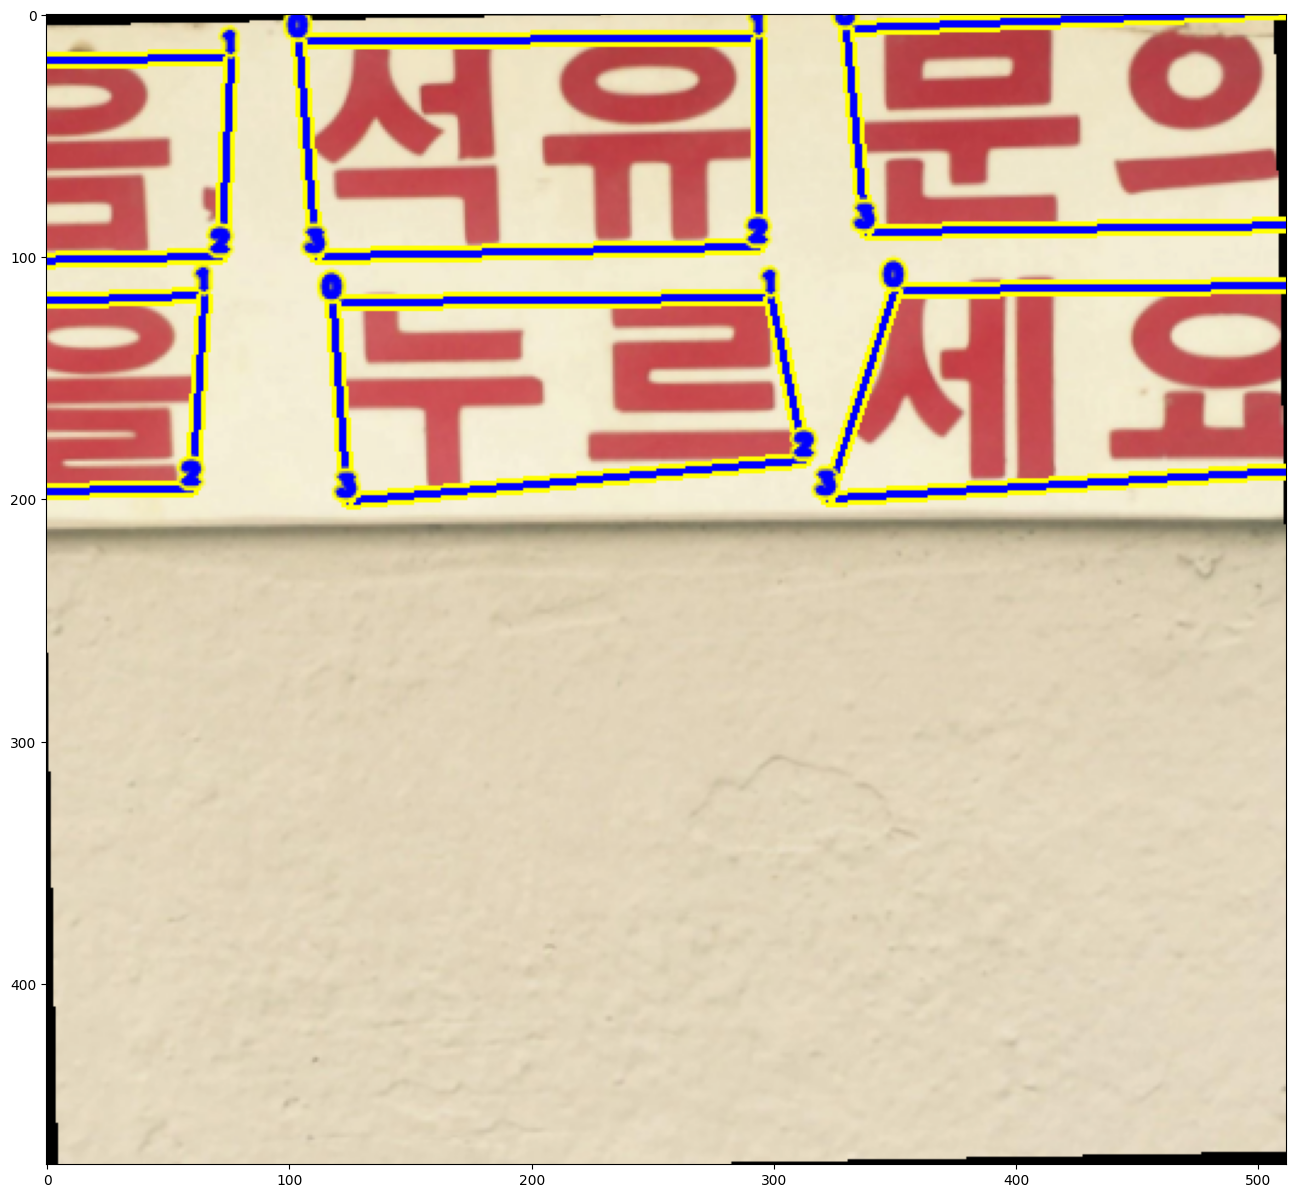

In [112]:

#plot_ground_truth(data0[0], data0[1])
vis = data0[0].copy()
invTrans = A.Compose([A.Normalize(mean = [ 0., 0., 0. ],std = [ 1/0.229, 1/0.224, 1/0.225 ],max_pixel_value=1/255),A.Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1/255, 1/255, 1/255 ],max_pixel_value=255)])
vis = invTrans(image = vis)['image'].astype(np.uint8)
draw_bboxes(vis,data0[1],double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)
plt.figure(figsize=(16, 16))
plt.imshow(vis)

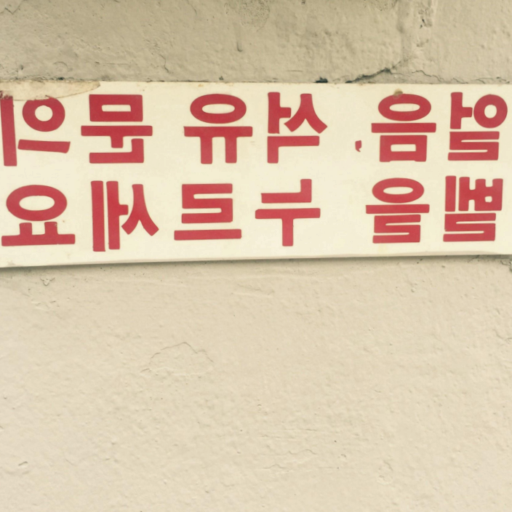

In [91]:
def convert_tensor_to_PIL(image_tensor):
    invTrans = A.Compose([A.Normalize(mean = [ 0., 0., 0. ],std = [ 1/0.229, 1/0.224, 1/0.225 ],max_pixel_value=1/255),A.Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1/255, 1/255, 1/255 ],max_pixel_value=255)])
    #invTrans = A.Compose([A.Normalize(mean = [ 0., 0., 0. ],std = [ 1, 1,1] ,max_pixel_value=1)])
    
    img = Image.fromarray((invTrans(image = image_tensor))['image'].astype(np.uint8))
    return img

convert_tensor_to_PIL(data0[0]).show()

In [50]:
Image.open('/opt/ml/input/data/ICDAR17_Korean/images/img_1001.jpg').height

2448

In [51]:
Image.open('/opt/ml/input/data/ICDAR17_Korean/images/img_1001.jpg').width

1836

In [69]:
def plot_ground_truth(dataset_output0, dataset_output1):
    SOURCE_IMG_PATH = "/opt/ml/input/data/ICDAR17_Korean/images"
    SOURCE_JSON_PATH = "/opt/ml/input/data/ICDAR17_Korean/ufo/train.json"

    with open(SOURCE_JSON_PATH, "rb") as f:
        source_val_json = json.load(f)


    img = convert_tensor_to_PIL(dataset_output0)
    
    fig, ax = plt.subplots(1,1)
    #ground_truth = source_val_json["images"][IMG_NAME]["words"]
    dataset_output1 = dataset_output1.astype(np.int32)

    for points in  dataset_output1:
    
        points = points[::-1]
        points = np.append(points,points[0]).reshape(-1,2)
        print(points)
        for prev_pos, next_pos in zip(points[:-1], points[1:]):
            ax.plot( [prev_pos[0], next_pos[0]], [prev_pos[1], next_pos[1]],color='r', linestyle='-', linewidth=1.5)
    ax.axis("off")
    ax.imshow(img)

    '''
    for word_key, word_val in ground_truth.items():

        word = np.array(word_val["points"])
        print(word)
        word =word[::-1]
        print('*****')
        print(word)
        word = np.append(word, word[0]).reshape(-1,2)
        print(word)
        print('---------')
        for prev_pos, next_pos in zip(word[:-1], word[1:]):
            ax.plot( [prev_pos[0], next_pos[0]], [prev_pos[1], next_pos[1]],color='r', linestyle='-', linewidth=1.5)
    ax.axis("off")
    ax.imshow(img)
    '''

[[ 126. 1037.]
 [ 592. 1037.]
 [ 607.  812.]
 [  80.  807.]
 [ 126. 1037.]]
---------
[[ 691. 1037.]
 [1155. 1037.]
 [1160.  803.]
 [ 678.  793.]
 [ 691. 1037.]]
---------
[[1267. 1022.]
 [1752. 1027.]
 [1767.  783.]
 [1252.  793.]
 [1267. 1022.]]
---------
[[ 124. 1295.]
 [ 557. 1299.]
 [ 573. 1080.]
 [ 109. 1089.]
 [ 124. 1295.]]
---------
[[ 718. 1314.]
 [1199. 1280.]
 [1168. 1094.]
 [ 708. 1089.]
 [ 718. 1314.]]
---------
[[1221. 1323.]
 [1767. 1299.]
 [1739. 1094.]
 [1296. 1089.]
 [1221. 1323.]]
---------


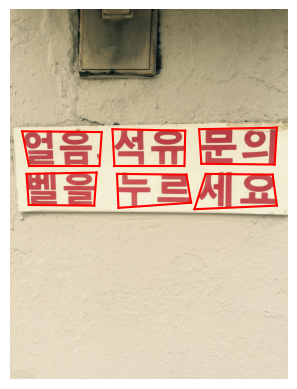

In [194]:
def plot_ground_truth(dataset_output0, dataset_output1):
    SOURCE_IMG_PATH = "/opt/ml/input/data/ICDAR17_Korean/images"
    SOURCE_JSON_PATH = "/opt/ml/input/data/ICDAR17_Korean/ufo/train.json"

    with open(SOURCE_JSON_PATH, "rb") as f:
        source_val_json = json.load(f)

    file_name ='img_1001.jpg'
    img = cv2.imread(osp.join(SOURCE_IMG_PATH, file_name))[:, :, ::-1]
    
    fig, ax = plt.subplots(1,1)
    ground_truth = source_val_json["images"][file_name]["words"]

    for word_key, word_val in ground_truth.items():

        word = np.array(word_val["points"])
        #print(word)
        word =word[::-1]
        #print('*****')
        #print(word)
        word = np.append(word, word[0]).reshape(-1,2)
        print(word)
        print('---------')
        for prev_pos, next_pos in zip(word[:-1], word[1:]):
            ax.plot( [prev_pos[0], next_pos[0]], [prev_pos[1], next_pos[1]],color='r', linestyle='-', linewidth=1.5)
    ax.axis("off")
    ax.imshow(img)
plot_ground_truth(0,0)

In [1]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

In [3]:
KEYPOINT_COLOR = (0, 255, 0) # Green

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=15):
    image = image.copy()

    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, (0, 255, 0), -1)
        
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)

In [5]:
image = cv2.imread('images/keypoints_image.jpg')

[ WARN:0@91.189] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('images/keypoints_image.jpg'): can't open/read file: check file path/integrity


In [2]:
keypoints = [
    (100, 100),
    (720, 410),
    (1100, 400),
    (1700, 30), 
    (300, 650),
    (1570, 590),
    (560, 800),
    (1300, 750), 
    (900, 1000),
    (910, 780),
    (670, 670),
    (830, 670), 
    (1000, 670),
    (1150, 670),
    (820, 900),
    (1000, 900),
]

In [6]:
vis_keypoints(image, keypoints)

AttributeError: 'NoneType' object has no attribute 'copy'

In [7]:
transform = A.Compose(
    [A.VerticalFlip(p=1)], 
    keypoint_params=A.KeypointParams(format='xy')
)
transformed = transform(image=image, keypoints=keypoints)
vis_keypoints(transformed['image'], transformed['keypoints'])

TypeError: image must be numpy array type